In [186]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from collections import defaultdict
import statistics
import _pickle as pickle
import json
import csv
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
aita_df = pd.read_csv("final_aita.csv")
print("The size of the dataframe is {}.".format(aita_df.shape))
aita_df.head()

The size of the dataframe is (956, 18).


,Unnamed: 0,id,title,score,num_comments,body,created,flair,uc1,uc2,uc3,uc4,uc5,uc6,uc7,uc8,uc9,uc10
0,0,azvko1,"UPDATE, AITA for despising my mentally handica...",72773,2027,"I'm back like I said I would be,. My [original...",1.552351e+09,UPDATE,Wow. OP's grandfather is a saint.,I'm glad your other family is coming through f...,This update is a needed one. My heart broke re...,1) I am so so happy that the rest of your fami...,"I'm glad you have such an amazing family, espe...",I've never clicked on a post as fast as when I...,>My parents have called me twice since Saturda...,Thank you for updating. If you ever need kind ...,Made me cry. Thank you for updating. Very grat...,"I understand your predicament, for I also come..."
1,1,cjetsa,UPDATE: AITA for wanting to go to the funeral ...,65293,2,I want to sincerely thank everyone who comment...,1.564452e+09,Update,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,aysa03,META: Too many AITA commenters advocate too qu...,53298,1648,I’ve become frustrated with how quick a lot of...,1.552092e+09,META,Sometimes I'm surprised by how quickly people ...,Too right. This is why I often remind people ...,"Honestly, if some upvoted internet strangers a...","This is a validation seeking sub. Not all, but...","On the flipside, not that I entirely disagree ...",I wish someone would have told me to run at th...,I’m surprised with how many people tell people...,I'm all for giving a chance and having an open...,On the flip side I think too many people are q...,"Eh, when I read a post where an OP is very cle..."
3,3,cihc3z,AITA for telling my extended family how many m...,49970,5386,We had a family dinner this evening. My family...,1.564262e+09,Everyone Sucks,I think everything that needs to be said on ei...,INFO\nHow could everyone possibly know her bod...,Was Jerry Springer there? Seems like Jerry Spr...,~~Temporarily locking this to clean it up.~~\n...,NTA. \n\nI feel like everyone voting ESH think...,NTA\n\nYour sister needed that.,NTA - People really need to learn not to dish ...,\nNTA. \n1. She started the personal attacks o...,ESH One person making personal attacks doesn’t...,NTA.\n\nYour sister made it personal and could...
4,4,cnml52,AITA for suggesting my 7yo name his new stuffe...,48430,4333,Pretty much the title. My son won a stuffed ti...,1.565304e+09,No A-holes here,Locking down this post for all the usual reaso...,NAH - \n\nHe's your son but I'll tell you righ...,NAH but maybe refer to it as tig as much as yo...,NAH\n\nInappropriate? Yes.\nStill funny? Also ...,"NAH, but this story reminded me of when I was ...","NAH . You jokingly suggested a name, it's not ...","NTA. I had a toy monkey my father called ""Beni...",NAH \n\n\nHAHAHAHAHAHAHA,NTA. This is hilarious.,NAH\n\nWhile your joke is very funny at least ...


In [3]:
aita_df.columns

Index(['Unnamed: 0', 'id', 'title', 'score', 'num_comments', 'body', 'created',
       'flair', 'uc1', 'uc2', 'uc3', 'uc4', 'uc5', 'uc6', 'uc7', 'uc8', 'uc9',
       'uc10'],
      dtype='object')

In [23]:
aita_df.flair.value_counts()

Not the A-hole            608
Asshole                   170
No A-holes here            64
Everyone Sucks             46
Update                     16
UPDATE                     15
META                       13
Probably Fake               3
not the a-hole              2
Not enough info             2
Fake Story                  1
Not the A-hole (oof)        1
everyone sucks              1
Record Setting Asshole      1
probably fake               1
weeabo h8r                  1
Actually Meta               1
TL;DR                       1
Shitpost                    1
META Asshole                1
Name: flair, dtype: int64

# Missing Data

The missing data isn't because we have incorrectly scrapped the data from the subreddit but rather it is when a moderator(mod) choses to lock the thread early. When a mod does this, it stops all new comments from being uploaded. So the missing data is from user comments where it was locked after the 2nd or 3rd user comment thus the missing data. Therefore we will just fill these missing data with 'No comments allowed'.

In [47]:
aita_df.isnull().sum()

Unnamed: 0      0
id              0
title           0
score           0
num_comments    0
body            0
created         0
flair           0
uc1             0
uc2             0
uc3             0
uc4             0
uc5             0
uc6             0
uc7             0
uc8             0
uc9             0
uc10            0
dtype: int64

In [6]:
aita_df[aita_df['body'].isnull()]

,Unnamed: 0,id,title,score,num_comments,body,created,flair,uc1,uc2,uc3,uc4,uc5,uc6,uc7,uc8,uc9,uc10
348,348,ajtjnd,"META: Can we all agree that, in general, peopl...",14282,625,NaN,1.548479e+09,META,\nIf you want your comment to count toward jud...,Can we see the photo of the seagull please,Well you made the seagull feel beautiful at least,How attractive was the seagull? Was it a sexy ...,I am also sad that you did not think or feel t...,Info: Have you ever thought about why you didn...,Yta. You set out to document memories of your ...,YTA but mildly. \n\nI would have gotten it if ...,YTA. Come on. All her photos are of you becaus...,YTA. Not because of the photos - you two clear...
764,764,a7uvyt,META. Stop wasting one or two sentences apolog...,5724,258,NaN,1.545314e+09,META,Sorry for formatting Im in mobile and my phone...,Sorry bro I’m on my flip phone rn and only hav...,I literally always see the ‘sorry for bad form...,"Ugh, it's like on Tales From Retail. ""Obligato...",Also: sorry English is not my native language....,"Almost as bad as (this is relevant later, I sw...",Can you post this on every sub reddit?,Sorry for the formatting issue... I suck at sp...,"Or when people say ""this is a throw away accou...",The only issue I'll ever have with formatting ...


In [7]:
aita_df['body'].fillna('No story. META post', inplace = True)

In [16]:
aita_df[aita_df['flair'].isnull()]

,Unnamed: 0,id,title,score,num_comments,body,created,flair,uc1,uc2,uc3,uc4,uc5,uc6,uc7,uc8,uc9,uc10
211,211,d2uish,AITA for posting a tribute of my late-girlfrie...,18460,2422,I lost my late-girlfriend on 9/11 when TWC tow...,1.568255e+09,NaN,\nIf you want your comment to count toward jud...,NTA those in glass houses shouldn't throw ston...,NTA. Why would she even say that shit about yo...,NTA - Had me go one way than the other\n\nFirs...,"NTA. Nearly ESH, but.... why on earth would sh...",NTA\n\nyou shouldn't have said that in the fir...,NTA - If you had waited and said it later woul...,"ESH, but that's OK because we're all only huma...",I'm split between NTA and ESH. She had no righ...,NTA - she asked you a favour and then proceede...
332,332,d2s8ht,WIBTA if I don’t disclose that I’m a product o...,14915,1189,I (22F) was adopted as an infant and never rea...,1.568246e+09,NaN,Whole lot of Be Civil rule violations happenin...,NTA\n\n\nThe whole point of having two wedding...,NTA\n\nYou already had a wedding in England wh...,"NTA\n\n""cope""??? Like, they'll get PTSD from s...",NTA. You had the traditional western Anglo wed...,Nta. Whats the point of 2 weddings if both are...,NTA. \n\n> I’m of the opinion that they’re all...,>Also during the English wedding I sided with ...,NTA. If you served meat at a Hindu wedding in ...,NTA. This is why you had to separate weddings....
407,407,awhhts,AITA Changing someone’s instagram password for...,12594,770,I got an email that “my” account name had been...,1.551560e+09,NaN,\nIf you want your comment to count toward jud...,"MAJOR NTA. \n\nSAME PROBLEM, what is up with f...",[deleted],NTA but she won't understand.,NTA I’m Christian but Christians who pull this...,"NTA, that much worship isn't really healthy. S...",NTA. She's the one being ungrateful and delusi...,"NTA- the Lord giveth, and the Lord taketh away","NTA. Also, if she saying ""she deserves this"", ...",NTA. God changed his mind about her needing a ...
427,427,cr4uat,"AITA for having an ""unhealthy relationship"" wi...",12082,1908,This is something I did not put much thought i...,1.565982e+09,NaN,\nIf you want your comment to count toward jud...,This article mentions that it's easy for a dog...,YTA. This is something your son will completel...,YTA. Change the dog's name. It's not that hard...,YTA. Teaching your son that he can have a dog ...,"Yta, you should have realized that this could ...","YTA. Would YOU like to constantly hear ""sit, t...",YTA. You should've anticipated this as a paren...,YTA. It seems like you don’t want to upset Kri...,YTA. \n \nYou have reduced the uniqueness and ...
498,498,bg0yvp,AITA for charging a deaf person for the intern...,10513,860,"Hello,\n\n&#x200B;\n\nI wanted to ask: AITA fo...",1.555961e+09,NaN,#[State of the Subreddit](https://www.reddit.c...,Just wanted to pop in and point something out ...,All I really have to say is that you’re awesom...,"You- did a really good, brave, mature thing he...",You're a a great person-that was A+ adulting.,"Wow, what an emotionally mature and level-head...","Hey OP, I created a throwaway because I post o...",Just keep in mind that if these two people REA...,You are a bigger person than I am! I would hav...,What?!? I really don’t get all the answers tha...
710,710,bmk0n9,WIBTA if I ask my dead wife's best friend to s...,6339,556,My wife and I have been together since college...,1.557438e+09,NaN,\nIf you want your comment to count toward jud...,I'm concerned about the 'make her mommy' part....,NTA\n\nI was going to say NAH until \n\n>She k...,NTA\n\nI think you need to establish some firm...,"NTA\n\n&#x200B;\n\n> Now, she asks me if we ca...","NTA, but have care.\n\nGrieving is weird. And ...","NTA- \n\nShe was asked to help, which should b...",NTA. I understand Sarah is trying to keep a pr...,NTA but consider your daughter’s experience of...,NAH. You aren't wrong for wanting to set boun...
860,860,cz3z4p,WIBTA if I don’t invite my morbidly obese brot...,4758,439

In [41]:
aita_df.loc[(aita_df['id'] == 'cr4uat'), 'flair'] = 'Asshole'

In [43]:
aita_df['flair'].fillna('Not the A-hole', inplace=True)

In [45]:
aita_df[aita_df.isnull().any(axis=1)]

,Unnamed: 0,id,title,score,num_comments,body,created,flair,uc1,uc2,uc3,uc4,uc5,uc6,uc7,uc8,uc9,uc10
1,1,cjetsa,UPDATE: AITA for wanting to go to the funeral ...,65293,2,I want to sincerely thank everyone who comment...,1.564452e+09,Update,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,31,d1ti7b,Update: AITA for shutting down all black names...,34300,2,https://www.reddit.com/r/AmItheAsshole/comment...,1.568077e+09,TL;DR,Due to the nature of this topic we unfortunate...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,584,aq7ury,"Update! AITA for calling my brothers gf ""miss ...",8284,18,I just want to start by saying holy hell. I di...,1.550101e+09,Asshole,Getting way too close to reading like you're l...,[removed],[removed],[removed],NaN,NaN,NaN,NaN,NaN,NaN
778,778,b8k6z1,UPDATE! AITA for not telling my boyfriend I kn...,5611,2,Hey again guys! Thank you all so much for the ...,1.554245e+09,Update,[Link to original](https://www.reddit.com/r/Am...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
aita_df.fillna("No comments allowed", inplace=True)

# Flair 

In [172]:
aita_df['flair'].value_counts()

Not the A-hole            614
Asshole                   171
No A-holes here            64
Everyone Sucks             46
Update                     16
UPDATE                     15
META                       13
Probably Fake               3
not the a-hole              2
Not enough info             2
Fake Story                  1
Not the A-hole (oof)        1
everyone sucks              1
Record Setting Asshole      1
probably fake               1
weeabo h8r                  1
Actually Meta               1
TL;DR                       1
Shitpost                    1
META Asshole                1
Name: flair, dtype: int64

In [182]:
aita_df['flair'].replace(['Not the A-hole', 'not the a-hole','Not the A-hole (oof)', 
                          'Asshole','Record Setting Asshole','weeabo h8r', 'Shitpost', 'META Asshole',
                          'No A-holes here', 
                          'Everyone Sucks', 'everyone sucks', 
                          'Update', 
                          'Not enough info', 'TL;DR',
                          'Probably Fake', 'probably fake', 'Fake Story',
                          'Actually Meta'], 
                         ['NTA', 'NTA', 'NTA', 
                          'YTA', 'YTA', 'YTA', 'YTA', 'YTA',
                          'NAH', 
                          'ESH', 'ESH', 
                          'UPDATE', 
                          'INFO', 'INFO',
                          'FAKE', 'FAKE', 'FAKE',
                          'META'], inplace = True)

In [183]:
aita_df['flair'].value_counts()

NTA       617
YTA       175
NAH        64
ESH        47
UPDATE     31
META       14
FAKE        5
INFO        3
Name: flair, dtype: int64

# Created On - Feature

In [188]:
aita_df['created'] = aita_df['created'].apply(lambda x: datetime.utcfromtimestamp(x))

In [191]:
aita_df['year'] = aita_df['created'].apply(lambda x: x.year)

In [193]:
aita_df['month'] = aita_df['created'].apply(lambda x: x.month)

In [195]:
aita_df['year'].value_counts()

2019    891
2018     65
Name: year, dtype: int64

# Word Count - Feature

A key feature that we can extract from the text is the word count. The word count will include stopwords but it will give us insights like how much the average user types for their title, story and comments. And we can see if these word counts are affected by seasonality or certain themes later on.

In [49]:
aita_df['body_wordcount'] = aita_df['body'].apply(lambda x: len(x.split()))
aita_df['title_wordcount'] = aita_df['title'].apply(lambda x: len(x.split()))

In [52]:
uc = []
for num in range(1,11):
    uc.append('uc{}_wordcount'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(uc[counter])] = aita_df['uc{}'.format(col)].apply(lambda x: len(x.split()))
    counter += 1

# Age - feature

Another key insight we can obtain from some of the stories is that the user sometimes place age. By using the age we can get a general understanding of the common age bracket. For now we will just grab the first age of male and female in the stories. Another option is using the median of all ages located. 

In [56]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\dF|m')
male_age = re.findall(male_age_re, aita_df['body'][3])
female_age = re.findall(female_age_re, aita_df['body'][3])

In [59]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\d[Ff]')
aita_df['male_age'] = aita_df['body'].apply(lambda x: re.findall(male_age_re, x))
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['female_age'] = aita_df['body'].apply(lambda x: re.findall(female_age_re, x))
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: re.sub(r'M|m', r'', str(x)))
aita_df['male_age'] = aita_df['male_age'].astype(np.int64)
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: re.sub(r'F|f', r'', str(x)))
aita_df['female_age'] = aita_df['female_age'].astype(np.int64)

# Word cleaning

We will begin cleaning the text so we can prepare it for further analysis and modelling. We will be removing all digits, making all text lowercase and getting rid of punctuation and stopwords. Stopwords are words like 'all', 'same' 'if' which are words search engine use to ignore. Lemmatization is the process of reducing inflectional forms and derive forms of words related to a comman base. E.g. different -> differ, boy's -> boy.

In [61]:
def word_digit_clean(word):
    word = ''.join([i for i in word if not i.isdigit()])    
    html_tags = re.compile('<.*?>')
    return word

In [62]:
aita_df['body_clean'] = aita_df['body'].apply(lambda x: word_digit_clean(x))
aita_df['title_clean'] = aita_df['title'].apply(lambda x: word_digit_clean(x))
uc = []
for num in range(1,11):
    uc.append('uc{}_clean'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(uc[counter])] = aita_df['uc{}'.format(col)].apply(lambda x: word_digit_clean(x))
    counter += 1

In [63]:
tokenizer = RegexpTokenizer(r'\w+')
aita_df['body_clean'] = aita_df['body_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
for col in range(1, 11):
    aita_df['uc{}_clean'.format(col)] = aita_df['uc{}_clean'.format(col)].apply(lambda x:tokenizer.tokenize(x.lower()))
    counter += 1

In [64]:
def remove_stopwords(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

In [65]:
aita_df['body_clean'] = aita_df['body_clean'].apply(lambda x: remove_stopwords(x))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: remove_stopwords(x))
for col in range(1, 11):
    aita_df['uc{}_clean'.format(col)] = aita_df['uc{}_clean'.format(col)].apply(lambda x: remove_stopwords(x))
    counter += 1

In [66]:
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [67]:
aita_df['body_clean'] = aita_df['body_clean'].apply(lambda x: word_lemmatizer(x))
aita_df['title_clean'] = aita_df['title_clean'].apply(lambda x: word_lemmatizer(x))
for col in range(1, 11):
    aita_df['uc{}_clean'.format(col)] = aita_df['uc{}_clean'.format(col)].apply(lambda x: word_lemmatizer(x))
    counter += 1

# Collocation

In [68]:
def colloc(word_pair):
    colloc_temp = dict()
    for colloc in word_pair:
        if colloc in colloc_temp:
            colloc_temp[colloc] += 1
        else:
            colloc_temp[colloc] = 1
    colloc = [[keys,values] for keys, values in colloc_temp.items() ]
    return colloc

In [69]:
def colloc_tolist(word_pair):
    colloc_temp = []
    for row in word_pair:
        for col in row:
            colloc_temp.append(col)
    return colloc_temp

In [70]:
def colloc_todict(word_pair):
    colloc_temp = dict()
    for colloc in word_pair:
        for row in colloc:
            if row in colloc_temp:
                colloc_temp[row] += 1
            else:
                colloc_temp[row] = 1
    return colloc_temp

In [74]:
bg_measures = BigramAssocMeasures()
def dataframe_colloc(dataframe, column, target):
    dataframe[column] = dataframe[target].apply(lambda x: nltk.word_tokenize(x))
    dataframe[column] = dataframe[column].apply(lambda x: BigramCollocationFinder.from_words(x))
    dataframe[column] = dataframe[column].apply(lambda x: x.nbest(bg_measures.likelihood_ratio, 10))
    dataframe[column] = dataframe[column].apply(lambda x: colloc(x))
    return dataframe[column]

In [236]:
aita_df.columns

Index(['Unnamed: 0', 'title', 'author', 'likes', 'comments', 'story',
       'user_comment1', 'user_comment2', 'user_comment3', 'user_comment4',
       'user_comment5', 'user_comment6', 'user_comment7', 'user_comment8',
       'user_comment9', 'user_comment10', 'story_wordcount', 'title_wordcount',
       'user_comment1_wordcount', 'user_comment2_wordcount',
       'user_comment3_wordcount', 'user_comment4_wordcount',
       'user_comment5_wordcount', 'user_comment6_wordcount',
       'user_comment7_wordcount', 'user_comment8_wordcount',
       'user_comment9_wordcount', 'user_comment10_wordcount', 'male_age',
       'female_age', 'story_clean', 'title_clean', 'user_comment1_clean',
       'user_comment2_clean', 'user_comment3_clean', 'user_comment4_clean',
       'user_comment5_clean', 'user_comment6_clean', 'user_comment7_clean',
       'user_comment8_clean', 'user_comment9_clean', 'user_comment10_clean'],
      dtype='object')

In [72]:
for value in range(1, 11):
    print('aita_df["uc{}_colloc"] = dataframe_colloc(aita_df, "uc", "uc{}_clean")'.format(value, value))

aita_df["uc1_colloc"] = dataframe_colloc(aita_df, "uc", "uc1_clean")
aita_df["uc2_colloc"] = dataframe_colloc(aita_df, "uc", "uc2_clean")
aita_df["uc3_colloc"] = dataframe_colloc(aita_df, "uc", "uc3_clean")
aita_df["uc4_colloc"] = dataframe_colloc(aita_df, "uc", "uc4_clean")
aita_df["uc5_colloc"] = dataframe_colloc(aita_df, "uc", "uc5_clean")
aita_df["uc6_colloc"] = dataframe_colloc(aita_df, "uc", "uc6_clean")
aita_df["uc7_colloc"] = dataframe_colloc(aita_df, "uc", "uc7_clean")
aita_df["uc8_colloc"] = dataframe_colloc(aita_df, "uc", "uc8_clean")
aita_df["uc9_colloc"] = dataframe_colloc(aita_df, "uc", "uc9_clean")
aita_df["uc10_colloc"] = dataframe_colloc(aita_df, "uc", "uc10_clean")


In [75]:
aita_df['body_colloc'] = dataframe_colloc(aita_df, 'body_colloc', 'body_clean')
aita_df['title_colloc'] = dataframe_colloc(aita_df, 'title_colloc', 'title_clean')
aita_df["uc1_colloc"] = dataframe_colloc(aita_df, "uc1", "uc1_clean")
aita_df["uc2_colloc"] = dataframe_colloc(aita_df, "uc2", "uc2_clean")
aita_df["uc3_colloc"] = dataframe_colloc(aita_df, "uc3", "uc3_clean")
aita_df["uc4_colloc"] = dataframe_colloc(aita_df, "uc4", "uc4_clean")
aita_df["uc5_colloc"] = dataframe_colloc(aita_df, "uc", "uc5_clean")
aita_df["uc6_colloc"] = dataframe_colloc(aita_df, "uc", "uc6_clean")
aita_df["uc7_colloc"] = dataframe_colloc(aita_df, "uc", "uc7_clean")
aita_df["uc8_colloc"] = dataframe_colloc(aita_df, "uc", "uc8_clean")
aita_df["uc9_colloc"] = dataframe_colloc(aita_df, "uc", "uc9_clean")
aita_df["uc10_colloc"] = dataframe_colloc(aita_df, "uc", "uc10_clean")

In [114]:
for num in range(1, 11):
    print('uc{}_colloc = colloc_tolist(aita_df["uc{}_colloc"])\nuc{}_colloc = colloc_todict(uc{}_colloc)\nuc{}_colloc = collections.OrderedDict(sorted(uc{}_colloc.items(), key = lambda x : x[1], reverse=True))'
          .format(num, num, num, num, num, num))

uc1_colloc = colloc_tolist(aita_df["uc1_colloc"])
uc1_colloc = colloc_todict(uc1_colloc)
uc1_colloc = collections.OrderedDict(sorted(uc1_colloc.items(), key = lambda x : x[1], reverse=True))
uc2_colloc = colloc_tolist(aita_df["uc2_colloc"])
uc2_colloc = colloc_todict(uc2_colloc)
uc2_colloc = collections.OrderedDict(sorted(uc2_colloc.items(), key = lambda x : x[1], reverse=True))
uc3_colloc = colloc_tolist(aita_df["uc3_colloc"])
uc3_colloc = colloc_todict(uc3_colloc)
uc3_colloc = collections.OrderedDict(sorted(uc3_colloc.items(), key = lambda x : x[1], reverse=True))
uc4_colloc = colloc_tolist(aita_df["uc4_colloc"])
uc4_colloc = colloc_todict(uc4_colloc)
uc4_colloc = collections.OrderedDict(sorted(uc4_colloc.items(), key = lambda x : x[1], reverse=True))
uc5_colloc = colloc_tolist(aita_df["uc5_colloc"])
uc5_colloc = colloc_todict(uc5_colloc)
uc5_colloc = collections.OrderedDict(sorted(uc5_colloc.items(), key = lambda x : x[1], reverse=True))
uc6_colloc = colloc_tolist(aita_df["uc6_collo

In [124]:
body_colloc = colloc_tolist(aita_df['body_colloc'])
body_colloc = colloc_todict(body_colloc)
body_colloc = collections.OrderedDict(sorted(body_colloc.items(), key = lambda x : x[1], reverse=True))
title_colloc = colloc_tolist(aita_df['title_colloc'])
title_colloc = colloc_todict(title_colloc)
title_colloc = collections.OrderedDict(sorted(title_colloc.items(), key = lambda x : x[1], reverse=True))
uc1_colloc = colloc_tolist(aita_df["uc1_colloc"])
uc1_colloc = colloc_todict(uc1_colloc)
uc1_colloc = collections.OrderedDict(sorted(uc1_colloc.items(), key = lambda x : x[1], reverse=True))
uc2_colloc = colloc_tolist(aita_df["uc2_colloc"])
uc2_colloc = colloc_todict(uc2_colloc)
uc2_colloc = collections.OrderedDict(sorted(uc2_colloc.items(), key = lambda x : x[1], reverse=True))
uc3_colloc = colloc_tolist(aita_df["uc3_colloc"])
uc3_colloc = colloc_todict(uc3_colloc)
uc3_colloc = collections.OrderedDict(sorted(uc3_colloc.items(), key = lambda x : x[1], reverse=True))
uc4_colloc = colloc_tolist(aita_df["uc4_colloc"])
uc4_colloc = colloc_todict(uc4_colloc)
uc4_colloc = collections.OrderedDict(sorted(uc4_colloc.items(), key = lambda x : x[1], reverse=True))
uc5_colloc = colloc_tolist(aita_df["uc5_colloc"])
uc5_colloc = colloc_todict(uc5_colloc)
uc5_colloc = collections.OrderedDict(sorted(uc5_colloc.items(), key = lambda x : x[1], reverse=True))
uc6_colloc = colloc_tolist(aita_df["uc6_colloc"])
uc6_colloc = colloc_todict(uc6_colloc)
uc6_colloc = collections.OrderedDict(sorted(uc6_colloc.items(), key = lambda x : x[1], reverse=True))
uc7_colloc = colloc_tolist(aita_df["uc7_colloc"])
uc7_colloc = colloc_todict(uc7_colloc)
uc7_colloc = collections.OrderedDict(sorted(uc7_colloc.items(), key = lambda x : x[1], reverse=True))
uc8_colloc = colloc_tolist(aita_df["uc8_colloc"])
uc8_colloc = colloc_todict(uc8_colloc)
uc8_colloc = collections.OrderedDict(sorted(uc8_colloc.items(), key = lambda x : x[1], reverse=True))
uc9_colloc = colloc_tolist(aita_df["uc9_colloc"])
uc9_colloc = colloc_todict(uc9_colloc)
uc9_colloc = collections.OrderedDict(sorted(uc9_colloc.items(), key = lambda x : x[1], reverse=True))
uc10_colloc = colloc_tolist(aita_df["uc10_colloc"])
uc10_colloc = colloc_todict(uc10_colloc)
uc10_colloc = collections.OrderedDict(sorted(uc10_colloc.items(), key = lambda x : x[1], reverse=True))

In [126]:
len(uc1_colloc)

2069

In [122]:
for num in range(1, 11):
    print('colloc["uc{}_pairs"] = list(uc{}_colloc.keys())[:1000]\ncolloc["uc{}_frequency"] = list(uc{}_colloc.values())[:1000]'
    .format(num, num, num, num))

colloc["uc1_pairs"] = list(uc1_colloc.keys())[:1000]
colloc["uc1_frequency"] = list(uc1_colloc.values())[:1000]
colloc["uc2_pairs"] = list(uc2_colloc.keys())[:1000]
colloc["uc2_frequency"] = list(uc2_colloc.values())[:1000]
colloc["uc3_pairs"] = list(uc3_colloc.keys())[:1000]
colloc["uc3_frequency"] = list(uc3_colloc.values())[:1000]
colloc["uc4_pairs"] = list(uc4_colloc.keys())[:1000]
colloc["uc4_frequency"] = list(uc4_colloc.values())[:1000]
colloc["uc5_pairs"] = list(uc5_colloc.keys())[:1000]
colloc["uc5_frequency"] = list(uc5_colloc.values())[:1000]
colloc["uc6_pairs"] = list(uc6_colloc.keys())[:1000]
colloc["uc6_frequency"] = list(uc6_colloc.values())[:1000]
colloc["uc7_pairs"] = list(uc7_colloc.keys())[:1000]
colloc["uc7_frequency"] = list(uc7_colloc.values())[:1000]
colloc["uc8_pairs"] = list(uc8_colloc.keys())[:1000]
colloc["uc8_frequency"] = list(uc8_colloc.values())[:1000]
colloc["uc9_pairs"] = list(uc9_colloc.keys())[:1000]
colloc["uc9_frequency"] = list(uc9_colloc.values())

In [131]:
colloc_df = pd.DataFrame()
colloc_df['body_pairs'] = list(body_colloc.keys())[:1000]
colloc_df['body_frequency'] = list(body_colloc.values())[:1000]
colloc_df['title_pairs'] = list(title_colloc.keys())[:1000]
colloc_df['title_frequency'] = list(title_colloc.values())[:1000]
colloc_df["uc1_pairs"] = list(uc1_colloc.keys())[:1000]
colloc_df["uc1_frequency"] = list(uc1_colloc.values())[:1000]
colloc_df["uc2_pairs"] = list(uc2_colloc.keys())[:1000]
colloc_df["uc2_frequency"] = list(uc2_colloc.values())[:1000]
colloc_df["uc3_pairs"] = list(uc3_colloc.keys())[:1000]
colloc_df["uc3_frequency"] = list(uc3_colloc.values())[:1000]
colloc_df["uc4_pairs"] = list(uc4_colloc.keys())[:1000]
colloc_df["uc4_frequency"] = list(uc4_colloc.values())[:1000]
colloc_df["uc5_pairs"] = list(uc5_colloc.keys())[:1000]
colloc_df["uc5_frequency"] = list(uc5_colloc.values())[:1000]
colloc_df["uc6_pairs"] = list(uc6_colloc.keys())[:1000]
colloc_df["uc6_frequency"] = list(uc6_colloc.values())[:1000]
colloc_df["uc7_pairs"] = list(uc7_colloc.keys())[:1000]
colloc_df["uc7_frequency"] = list(uc7_colloc.values())[:1000]
colloc_df["uc8_pairs"] = list(uc8_colloc.keys())[:1000]
colloc_df["uc8_frequency"] = list(uc8_colloc.values())[:1000]
colloc_df["uc9_pairs"] = list(uc9_colloc.keys())[:1000]
colloc_df["uc9_frequency"] = list(uc9_colloc.values())[:1000]
colloc_df["uc10_pairs"] = list(uc10_colloc.keys())[:1000]
colloc_df["uc10_frequency"] = list(uc10_colloc.values())[:1000]

In [132]:
colloc_df

,body_pairs,body_frequency,title_pairs,title_frequency,uc1_pairs,uc1_frequency,uc2_pairs,uc2_frequency,uc3_pairs,uc3_frequency,...,uc6_pairs,uc6_frequency,uc7_pairs,uc7_frequency,uc8_pairs,uc8_frequency,uc9_pairs,uc9_frequency,uc10_pairs,uc10_frequency
0,1,9544,1,5956,1,9178,1,8332,1,8327,...,1,8284,1,8445,1,8413,1,8347,1,8463
1,"(aita, edit)",41,"(aita, telling)",112,"(http, www)",660,"(sound, like)",14,"(sound, like)",20,...,"(sound, like)",14,"(sound, like)",17,"(sound, like)",19,"(sound, like)",17,"(sound, like)",15
2,"(year, old)",34,"(aita, wanting)",54,"(r, amitheasshole)",660,"(gon, na)",9,"(feel, like)",11,...,"(feel, like)",11,"(feel, like)",12,"(gon, na)",13,"(feel, like)",13,"(year, old)",9
3,"(feel, like)",31,"(aita, refusing)",48,"(amitheasshole, wiki)",657,"(good, luck)",7,"(gon, na)",9,...,"(can, not)",9,"(gon, na)",10,"(can, not)",11,"(can, not)",7,"(feel, like)",9
4,"(amitheasshole, comment)",25,"(update, aita)",25,"(com, r)",653,"(feel, like)",7,"(first, place)",9,...,"(gon, na)",9,"(can, not)",7,"(feel, like)",9,"(gon, na)",6,"(gon, na)",9
5,"(best, friend)",22,"(aita, asking)",24,"(reddit, com)",627,"(can, not)",7,"(nta, think)",7,...,"(year, old)",8,"(good, luck)",6,"(year, old)",8,"(every, right)",6,"(first, place)",8
6,"(big, deal)",21,"(aita, getting)",21,"(www, reddit)",624,"(big, deal)",6,"(year, old)",7,...,"(make, sure)",7,"(nothing, wrong)",6,"(big, deal)",7,"(good, luck)",6,"(can, not)",7
7,"(asked, could)",16,"(aita, letting)",19,"(action, performed)",620,"(nta, think)",6,"(acting, like)",7,...,"(nta, even)",6,"(even, though)",6,"(holy, shit)",6,"(deal, breaker)",5,"(even, though)",6
8,"(last, night)",14,"(aita, giving)",17,"(automatically, please)",560,"(first, place)",5,"(big, deal)",7,...,"(everyone, else)",6,"(nta, need)",6,"(nta, sound)",6,"(make, sure)",5,"(good, luck)",6
9,"(can, not)",13,"(best, friend)",15,"(contact, moderator)",553,"(make, sure)",5,"(let, know)",6,...,"(even, though)",6,"(either, way)",6,"(nta, want)",6,"(completely, reasonable)",5,"(good, idea)",5


In [133]:
colloc_df.drop(0, inplace = True)

In [138]:
colloc_df.to_csv('colloc.csv')

# Word value counts 

We will used the clean text from the columns, title, story, usercomments1-10 and determine its frequency of all the words. The goal of this is to create visualisation of what are the common words used for these features. We will visualise it in two ways through a wordcloud and a bar graph. Wordclouds are great for everyday viewers to get some insights from the visualisation however flaws such as longer words appear bigger creates it harder to truly understand the data. Thus the bar graph will implemented to supplement the word cloud. 

Interactive dashboards will also be planned.

In [134]:
body_wordlist = aita_df['body_clean'].str.split(expand = True).stack().value_counts().astype(int)
title_wordlist = aita_df['title_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc1_wordlist = aita_df['uc1_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc2_wordlist = aita_df['uc2_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc3_wordlist = aita_df['uc3_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc4_wordlist = aita_df['uc4_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc5_wordlist = aita_df['uc5_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc6_wordlist = aita_df['uc6_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc7_wordlist = aita_df['uc7_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc8_wordlist = aita_df['uc8_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc9_wordlist = aita_df['uc9_clean'].str.split(expand = True).stack().value_counts().astype(int)
uc10_wordlist = aita_df['uc10_clean'].str.split(expand = True).stack().value_counts().astype(int)

In [135]:
body_wordlist_dict = dict(body_wordlist)
title_wordlist_dict = dict(title_wordlist)
uc1_dict = dict(uc1_wordlist)
uc2_dict = dict(uc2_wordlist)
uc3_dict = dict(uc3_wordlist)
uc4_dict = dict(uc4_wordlist)
uc5_dict = dict(uc5_wordlist)
uc6_dict = dict(uc6_wordlist)
uc7_dict = dict(uc7_wordlist)
uc8_dict = dict(uc8_wordlist)
uc9_dict = dict(uc9_wordlist)
uc10_dict = dict(uc10_wordlist)

In [136]:
body, body_frequency = list(body_wordlist_dict.keys())[:1000], list(body_wordlist_dict.values())[:1000]
title, title_frequency = list(title_wordlist_dict.keys())[:1000], list(title_wordlist_dict.values())[:1000]
uc1, uc1_frequency = list(uc1_dict.keys())[:1000], list(uc1_dict.values())[:1000]
uc2, uc2_frequency = list(uc2_dict.keys())[:1000], list(uc2_dict.values())[:1000]
uc3, uc3_frequency = list(uc3_dict.keys())[:1000], list(uc3_dict.values())[:1000]
uc4, uc4_frequency = list(uc4_dict.keys())[:1000], list(uc4_dict.values())[:1000]
uc5, uc5_frequency = list(uc5_dict.keys())[:1000], list(uc5_dict.values())[:1000]
uc6, uc6_frequency = list(uc6_dict.keys())[:1000], list(uc6_dict.values())[:1000]
uc7, uc7_frequency = list(uc7_dict.keys())[:1000], list(uc7_dict.values())[:1000]
uc8, uc8_frequency = list(uc8_dict.keys())[:1000], list(uc8_dict.values())[:1000]
uc9, uc9_frequency = list(uc9_dict.keys())[:1000], list(uc9_dict.values())[:1000]
uc10, uc10_frequency = list(uc10_dict.keys())[:1000], list(uc10_dict.values())[:1000]

In [137]:
word_df = pd.DataFrame()
word_df = word_df.assign(body=body, body_frequency=body_frequency, title=title, title_frequency=title_frequency,
                        uc1=uc1, uc1_frequency=uc1_frequency, uc2=uc2, uc2_frequency=uc2_frequency, 
                        uc3=uc3, uc3_frequency=uc3_frequency, uc4=uc4, uc4_frequency=uc4_frequency, 
                        uc5=uc5, uc5_frequency=uc5_frequency, uc6=uc6, uc6_frequency=uc6_frequency, 
                        uc7=uc7, uc7_frequency=uc7_frequency, uc8=uc8, uc8_frequency=uc8_frequency, 
                        uc9=uc9, uc9_frequency=uc9_frequency, uc10=uc10, uc10_frequency=uc10_frequency)

In [139]:
word_df.to_csv('word_frequncy.csv')

In [140]:
body_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(body_wordlist_dict)
title_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(title_wordlist_dict)
uc1_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc1_dict)
uc2_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc2_dict)
uc3_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc3_dict)
uc4_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc4_dict)
uc5_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc5_dict)
uc6_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc6_dict)
uc7_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc7_dict)
uc8_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc8_dict)
uc9_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc9_dict)
uc10_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(uc10_dict)

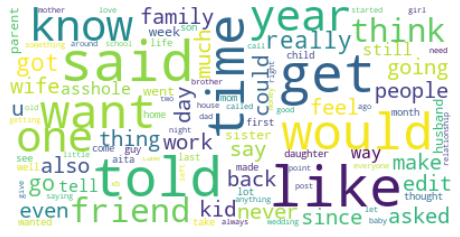

In [145]:
plt.imshow(body_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

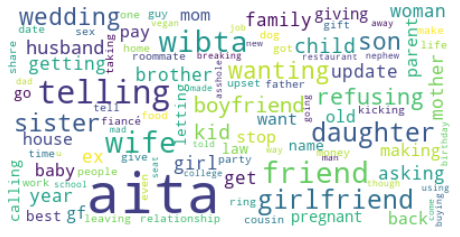

In [146]:
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

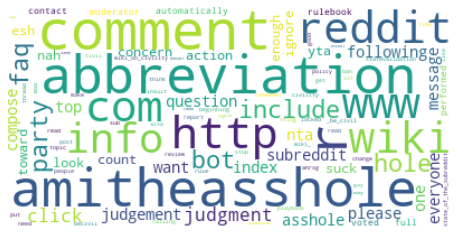

In [147]:
plt.imshow(uc1_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

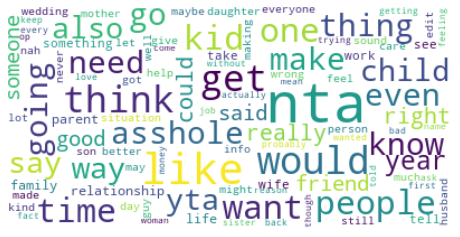

In [148]:
plt.imshow(uc2_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

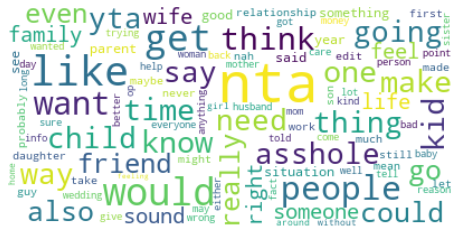

In [149]:
plt.imshow(uc3_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

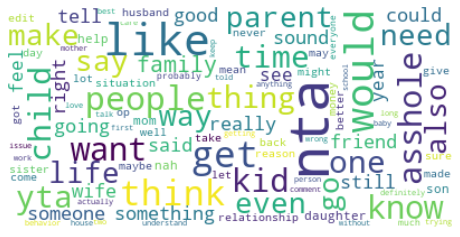

In [150]:
plt.imshow(uc4_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

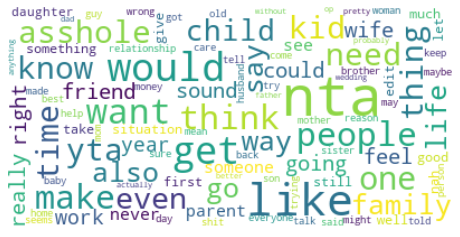

In [151]:
plt.imshow(uc5_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

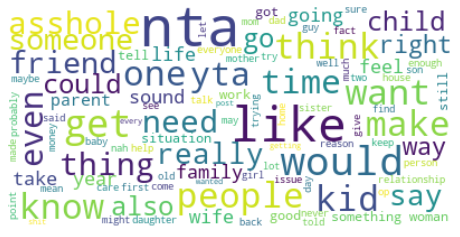

In [152]:
plt.imshow(uc6_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

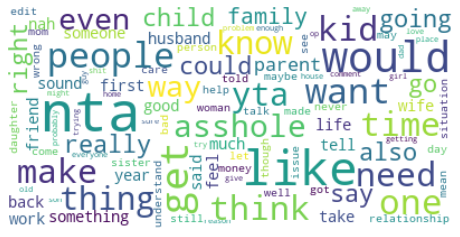

In [153]:
plt.imshow(uc7_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

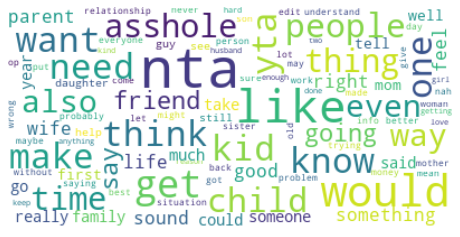

In [154]:
plt.imshow(uc8_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

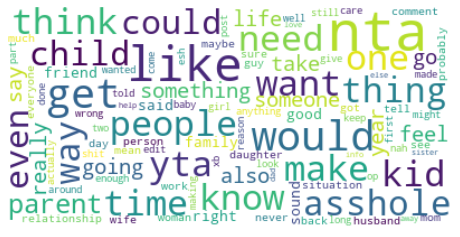

In [155]:
plt.imshow(uc9_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

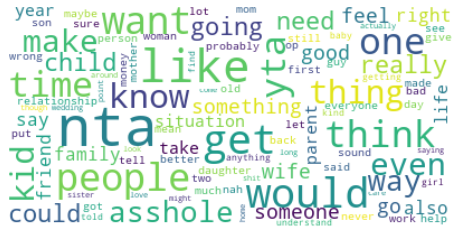

In [156]:
plt.imshow(uc10_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [157]:
body_wordcloud.to_file("body_wordcloud.png")
title_wordcloud.to_file("title_wordcloud.png")
uc1_wordcloud.to_file("uc1_wordcloud.png")
uc2_wordcloud.to_file("uc2_wordcloud.png")
uc3_wordcloud.to_file("uc3_wordcloud.png")
uc4_wordcloud.to_file("uc4_wordcloud.png")
uc5_wordcloud.to_file("uc5_wordcloud.png")
uc6_wordcloud.to_file("uc6_wordcloud.png")
uc7_wordcloud.to_file("uc7_wordcloud.png")
uc8_wordcloud.to_file("uc8_wordcloud.png")
uc9_wordcloud.to_file("uc9_wordcloud.png")
uc10_wordcloud.to_file("uc10_wordcloud.png")

NameError: name 'story_wordcloud' is not defined

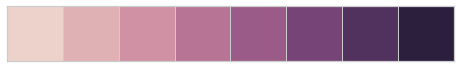

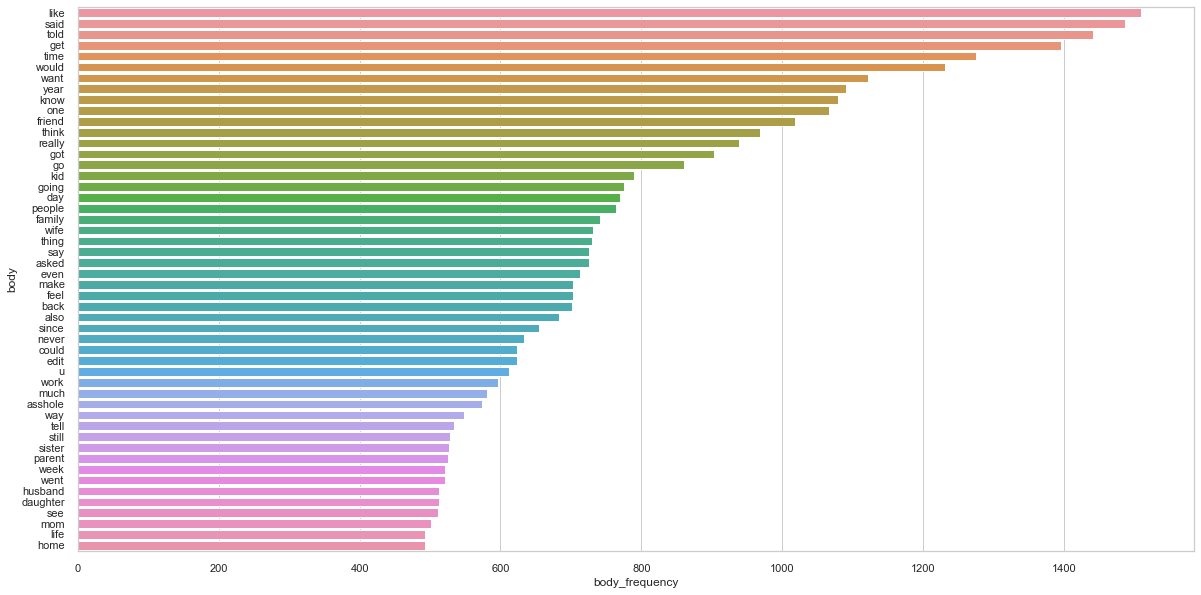

In [158]:
sns.set(style='whitegrid')
palettes = sns.palplot(sns.cubehelix_palette(8))
sns.set_palette(palettes)
plt.figure(figsize=(20, 10))
body_sns_plot = sns.barplot(x="body_frequency", y = "body", data = word_df[:50])

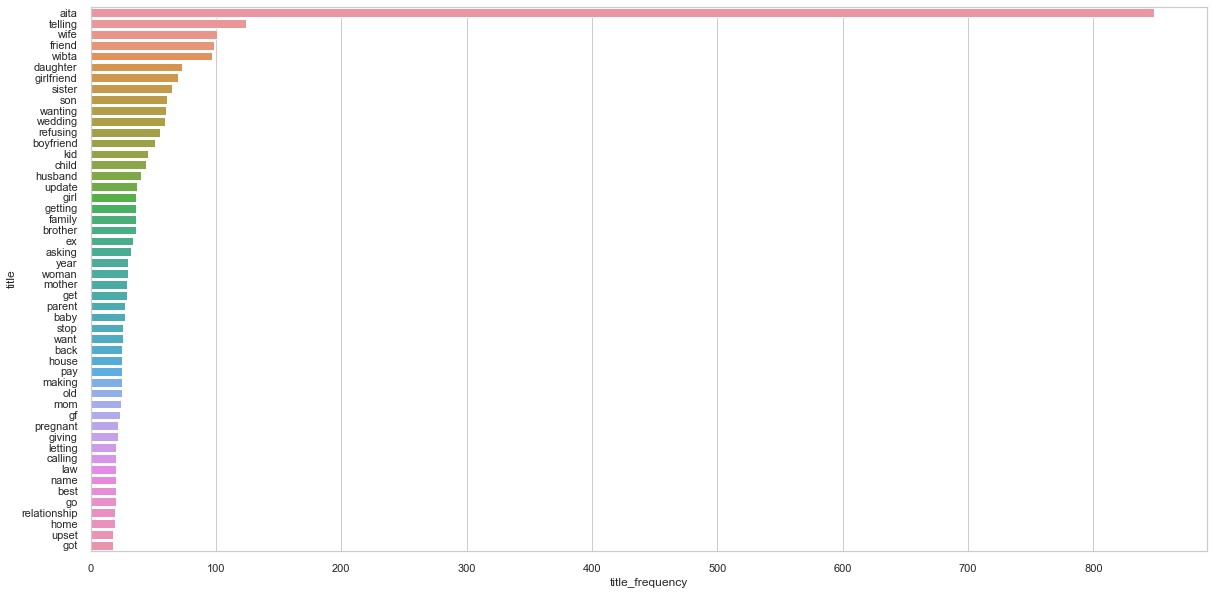

In [159]:
plt.figure(figsize=(20, 10))
sns.set(style='whitegrid')
title_sns_plot = sns.barplot(x="title_frequency", y = "title", data = word_df[:50])

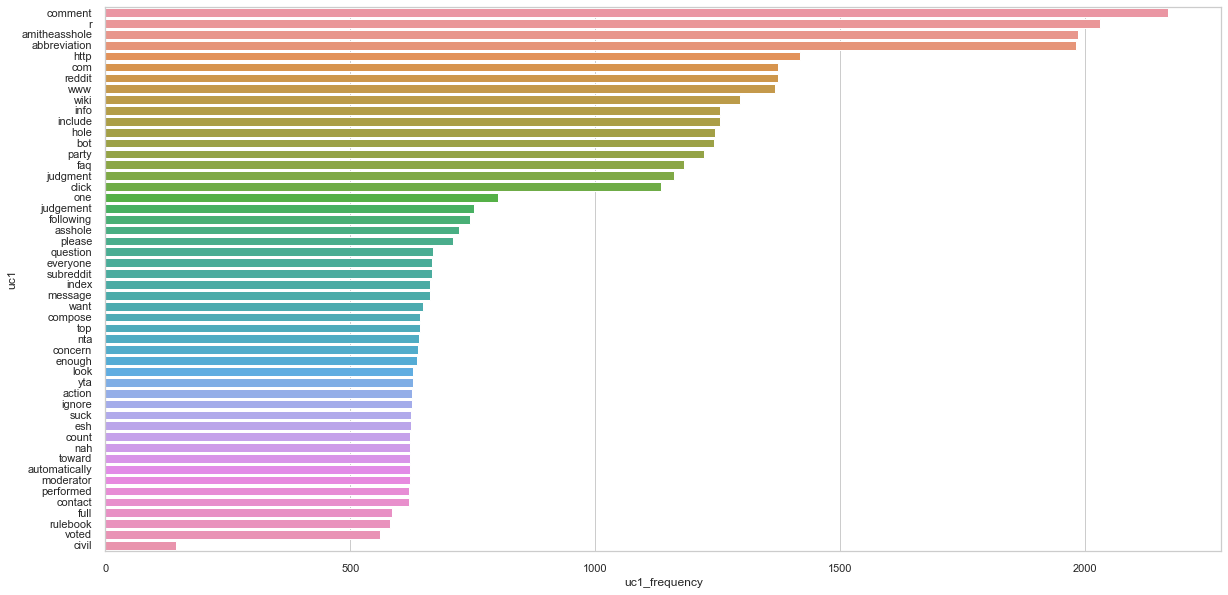

In [160]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc1_sns_plot = sns.barplot(x="uc1_frequency", y="uc1", data=word_df[:50])

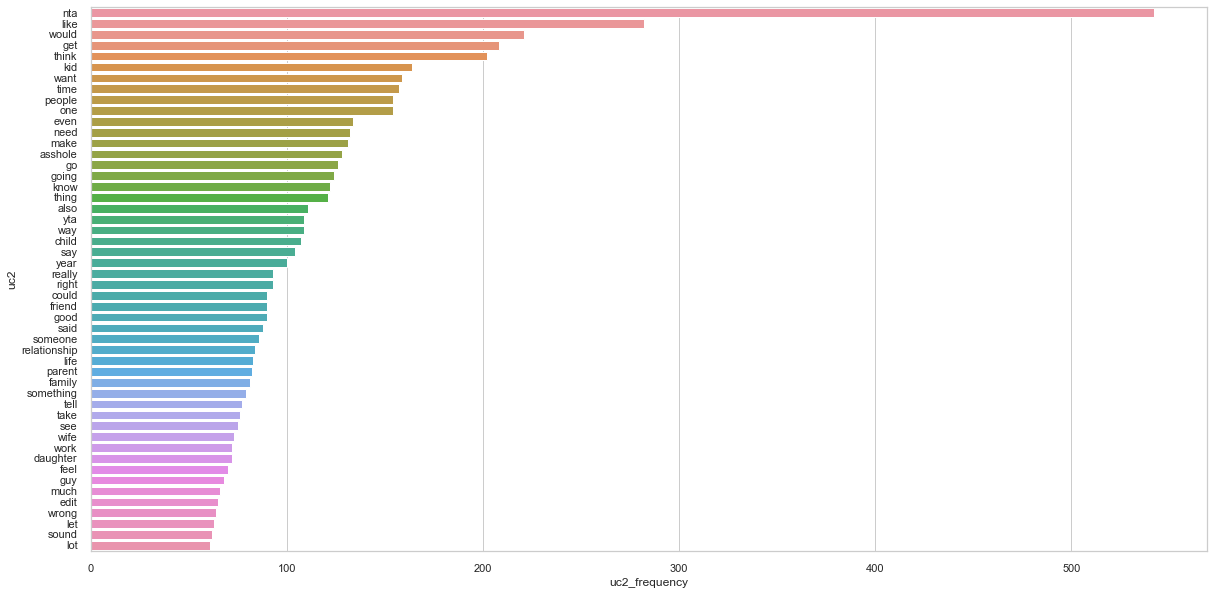

In [161]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc2_sns_plot = sns.barplot(x="uc2_frequency", y="uc2", data=word_df[:50])

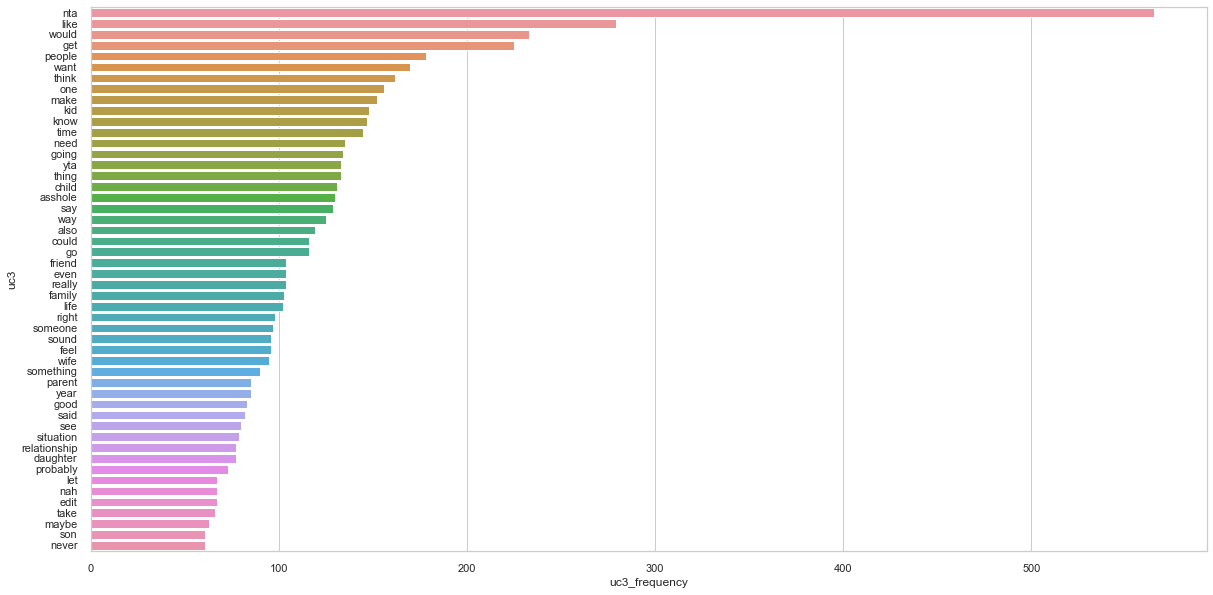

In [162]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc3_sns_plot = sns.barplot(x="uc3_frequency", y="uc3", data=word_df[:50])

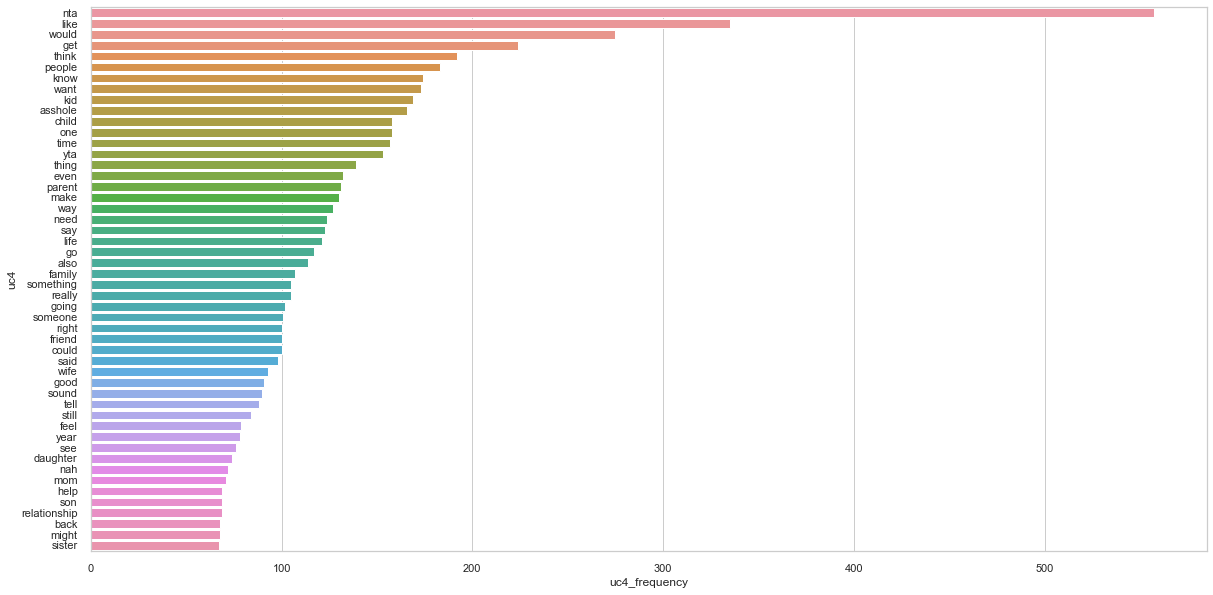

In [163]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc4_sns_plot = sns.barplot(x="uc4_frequency", y="uc4", data=word_df[:50])

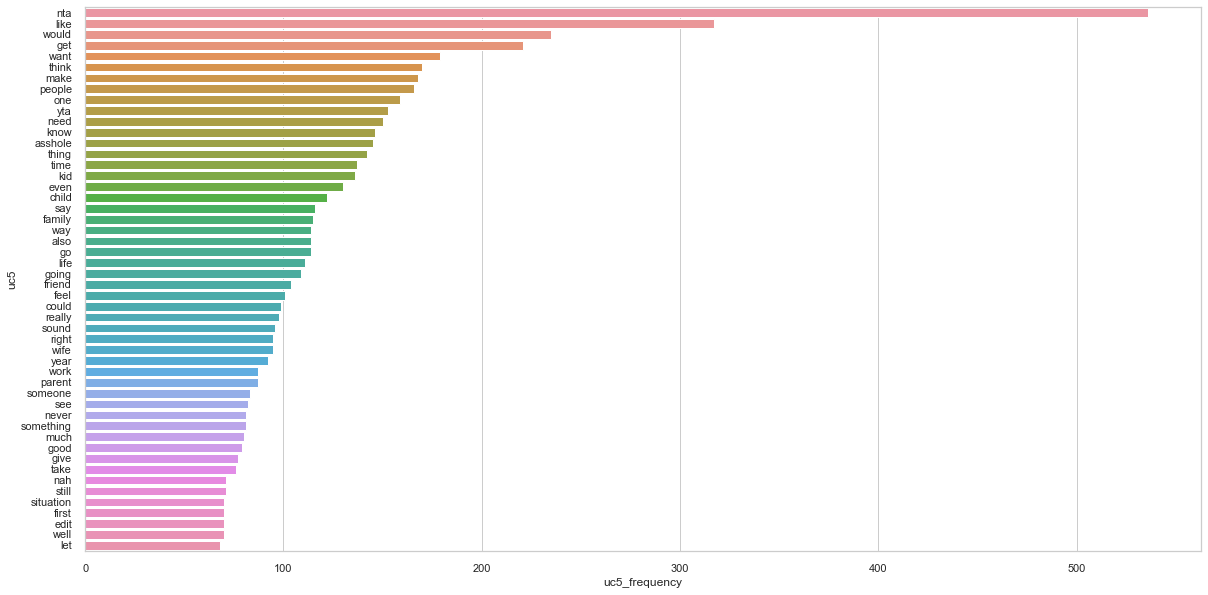

In [164]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc5_sns_plot = sns.barplot(x="uc5_frequency", y="uc5", data=word_df[:50])

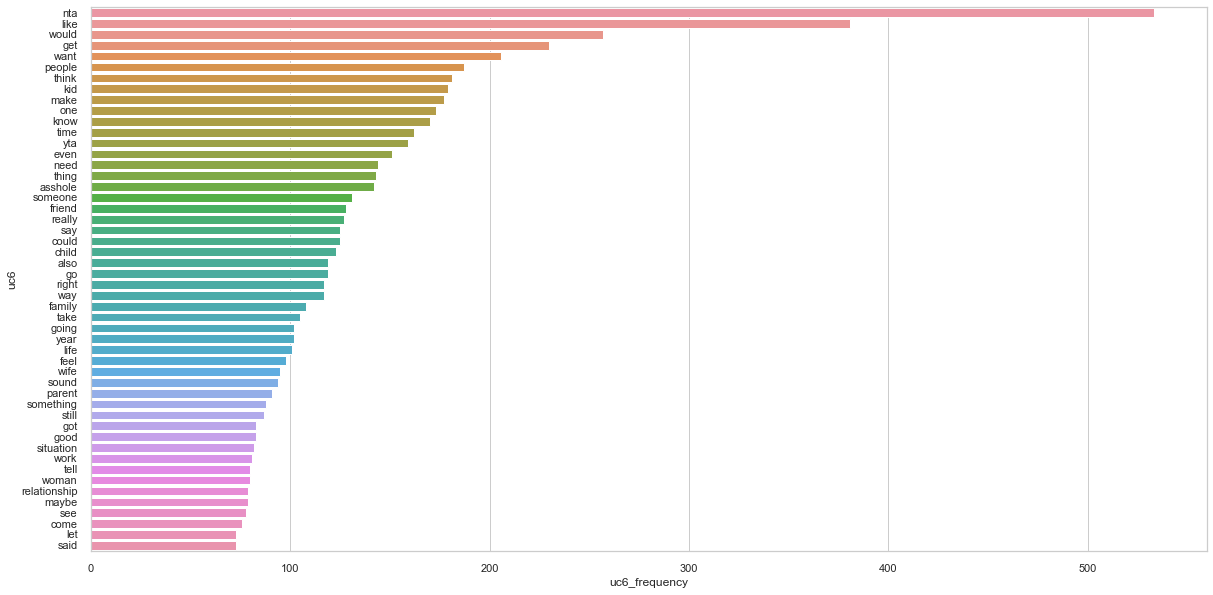

In [165]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc6_sns_plot = sns.barplot(x="uc6_frequency", y="uc6", data=word_df[:50])

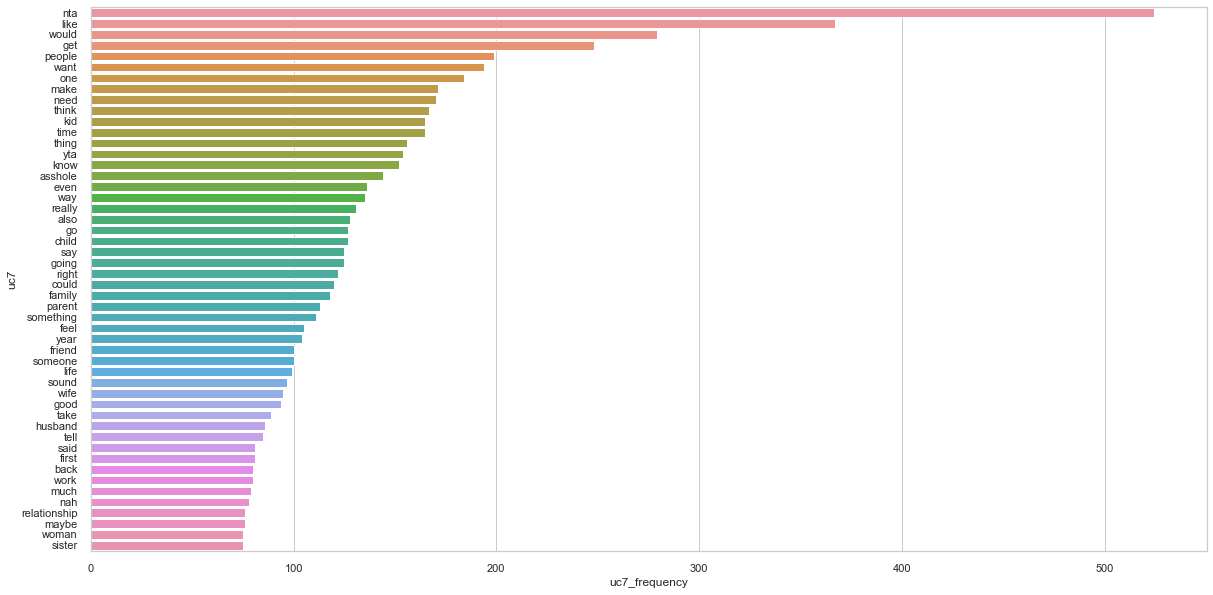

In [166]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc7_sns_plot = sns.barplot(x="uc7_frequency", y="uc7", data=word_df[:50])

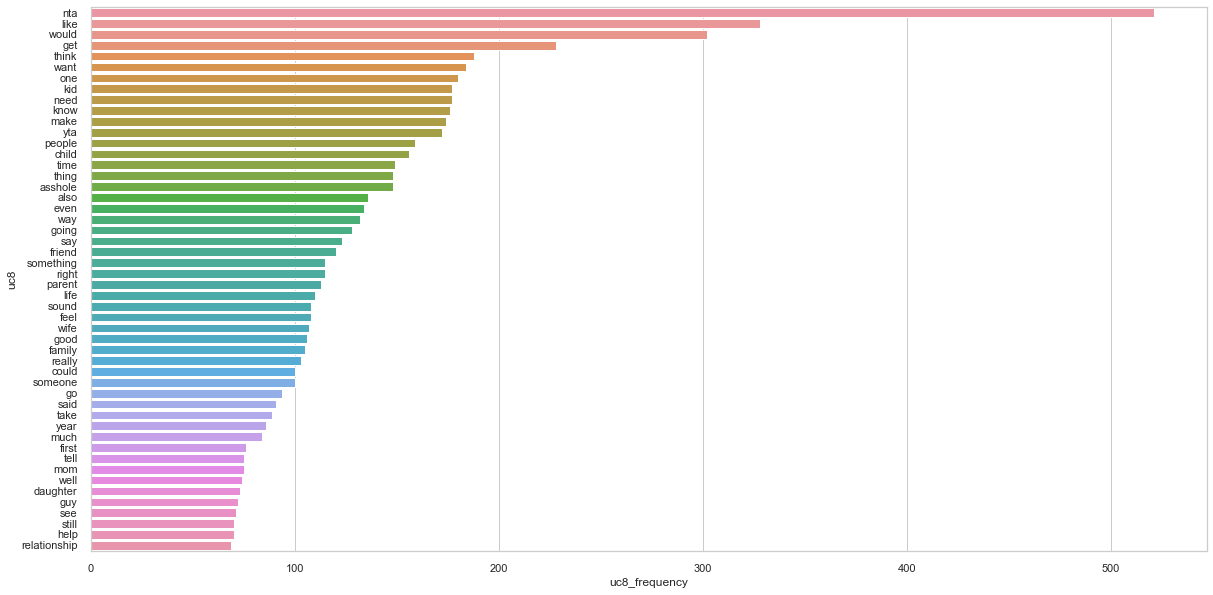

In [167]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc8_sns_plot = sns.barplot(x="uc8_frequency", y="uc8", data=word_df[:50])

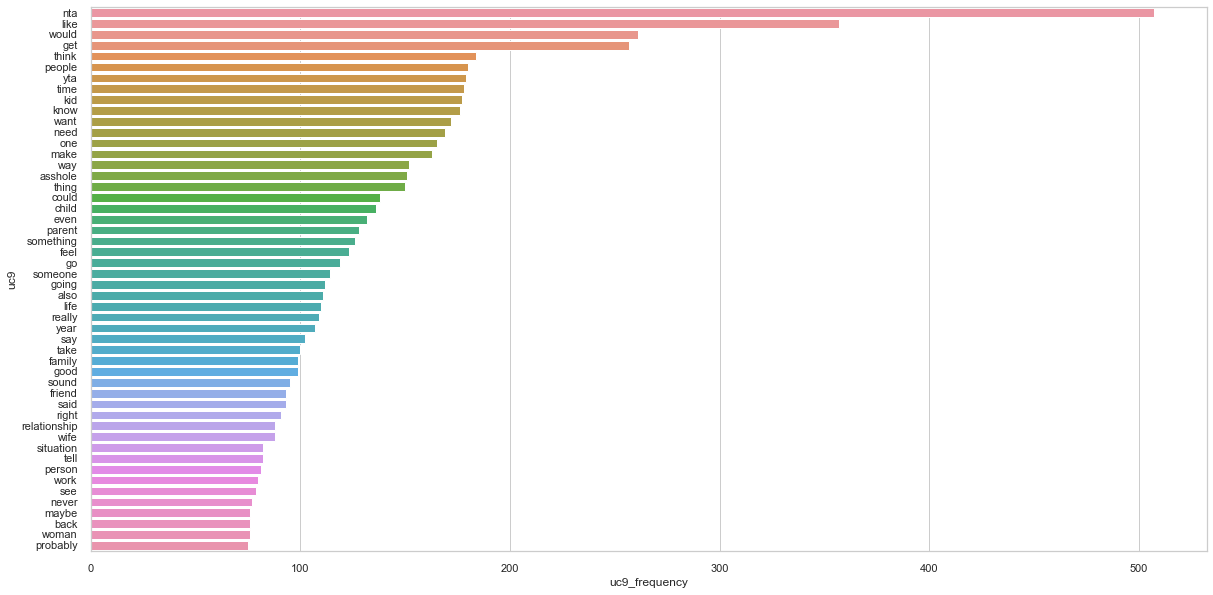

In [168]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc9_sns_plot = sns.barplot(x="uc9_frequency", y="uc9", data=word_df[:50])

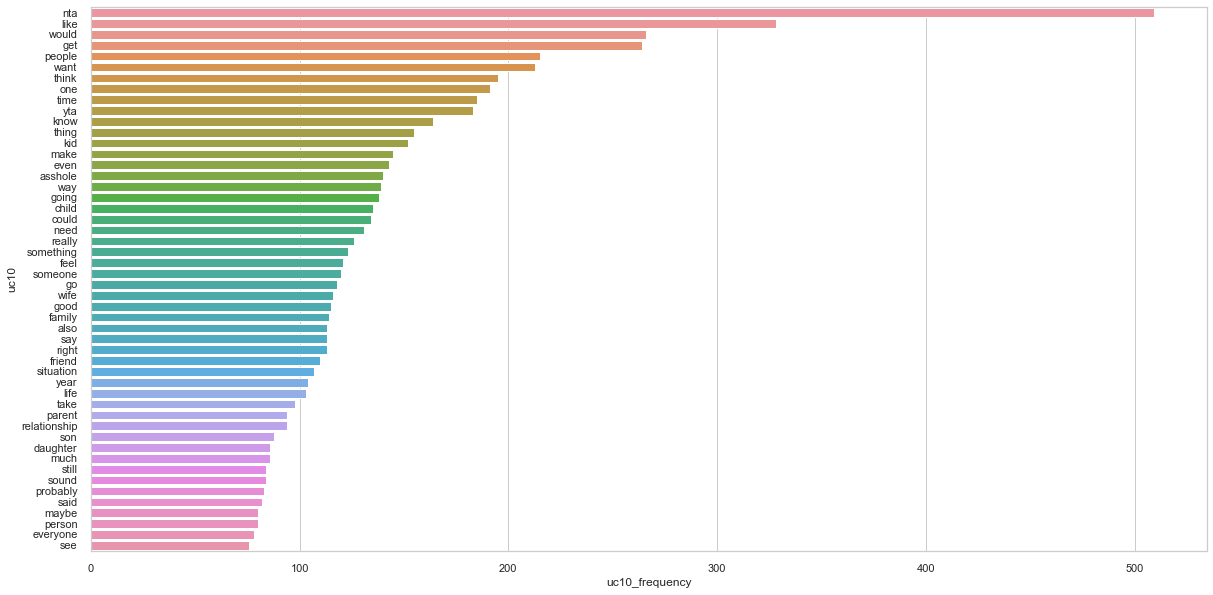

In [169]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
uc10_sns_plot = sns.barplot(x="uc10_frequency", y="uc10", data=word_df[:50])

In [170]:
story_sns_plot.figure.savefig("story_wordbar.png")
title_sns_plot.figure.savefig("title_wordbar.png")
uc1_sns_plot.figure.savefig("uc1_wordbar.png")
uc2_sns_plot.figure.savefig("uc2_wordbar.png")
uc3_sns_plot.figure.savefig("uc3_wordbar.png")
uc4_sns_plot.figure.savefig("uc4_wordbar.png")
uc5_sns_plot.figure.savefig("uc5_wordbar.png")
uc6_sns_plot.figure.savefig("uc6_wordbar.png")
uc7_sns_plot.figure.savefig("uc7_wordbar.png")
uc8_sns_plot.figure.savefig("uc8_wordbar.png")
uc9_sns_plot.figure.savefig("uc9_wordbar.png")
uc10_sns_plot.figure.savefig("uc10_wordbar.png")


NameError: name 'story_sns_plot' is not defined